In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
import warnings
import missingno as msno
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [2]:
loan_dataframe = pd.read_csv('Loan_Default.csv')

In [3]:
loan_dataframe.shape

(148670, 34)

Dataset Features:
* loan_limit (cf: conforming loan, ncf: non conforming loan) 
    -  A conforming loan is a mortgage that meets the dollar limits set by the Federal Housing Finance Agency (FHFA) and the funding criteria of Freddie Mac and Fannie Mae. In 2019 baseline loan limit was 484350$.
    - Mortgages that exceed the conforming loan limit are classified as nonconforming or jumbo mortgages.
* Gender (Male, Female, Not Availabe, Joint)
* approv_in_adv (pre, nopre): pre-approval is a preliminary evaluation of a potential borrower by a lender to determine whether they are likely to be approved for a loan
* loan_type (type1, type2, type3)
* loan_purpose (p1, p2, p3, p4)
* Credit_Worthiness(l1, l2):
    - L1 (Level 1): This typically represents the highest level of creditworthiness. Individuals or entities categorized under L1 are considered to have excellent credit histories
    - L2 (Level 2): This represents the next tier of creditworthiness, which is generally good but not as strong as L1. Individuals or entities categorized under L2 may have a good credit history with a few minor issues, such as occasional late payments or higher credit utilization
* open_credit (opc/nopc): Open credit is a pre-approved loan between a lender and a borrower. It allows the borrower to make repeated withdrawals up to a certain limit and then make subsequent repayments before the payments become due.
* business_or_commercial: b\c - business or commercial loan, nob\c - not a business or commercial loan  
* loan_amount
* rate_of_interest
* interest_rate_spread: the interest rate charged by banks on loans to private sector customers minus the interest rate paid by commercial or similar banks for demand, time, or savings deposits
* Upfront_charges
* term: The loan term in months (e.g., 360.0 for a 30-year mortgage).
* Neg_ammortization: Indicates whether the loan has negative amortization, e.g., "not_neg" (no negative amortization).
* interest_only: Indicates whether the loan is interest-only, e.g., "not_int" (not interest-only).
* lump_sum_payment: Indicates if a lump sum payment has been made, e.g., "not_lpsm" (no lump sum payment), "lpsm" (lump sum payment made).
* property_value: The value of the property being financed.
* construction_type: The type of construction, e.g., "sb" (site-built).
* occupancy_type: The occupancy type of the property, e.g., "pr" (primary residence), "sec" (secondary residence).
* Secured_by: What the loan is secured by, e.g., "home" (secured by home).
* total_units: The number of units in the property (e.g., "1U" for a single-unit property).
* income: The borrower's income.
* credit_type: The credit bureau providing the credit score, e.g., "EXP" (Experian), "EQUI" (Equifax), "CRIF" (CRIF High Mark).
* Credit_Score: The borrower's credit score.
* co-applicant_credit_type: The credit bureau providing the co-applicant's credit score, e.g., "CIB" (CIBIL).
* age: Age group of the primary applicant, e.g., "25-34," "35-44," etc.
* submission_of_application: How the loan application was submitted, e.g., "to_inst" (through institution), "not_inst" (not through institution).
* Region: Geographic region where the loan was issued, e.g., "north," "south."
* Security_Type: Type of security, e.g., "direct."
* dtir1 - percentage of gross monthly income that is used to pay monthly debt
* LTV - relative difference between the loan amount and the current market value of a home (the property_value)


In [4]:
pd.set_option('display.max_columns', None)
loan_dataframe.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [5]:
loan_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [6]:
#changing total_units column froma categorical to numerical by removing 'U' suffix and chaning type to int
loan_dataframe['total_units'] = loan_dataframe['total_units'].str.replace('U','').astype(int)

In [7]:
loan_dataframe.describe()

,ID,year,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,total_units,income,Credit_Score,LTV,Status,dtir1
count,148670.000000,148670.0,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,148670.000000,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,99224.500000,2019.0,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,1.021679,6957.338876,699.789103,72.746457,0.246445,37.732932
std,42917.476598,0.0,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,0.198521,6496.586382,115.875857,39.967603,0.430942,10.545435
min,24890.000000,2019.0,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,1.000000,0.000000,500.000000,0.967478,0.000000,5.000000
25%,62057.250000,2019.0,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,1.000000,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,99224.500000,2019.0,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,1.000000,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,136391.750000,2019.0,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,1.000000,8520.000000,800.000000,86.184211,0.000000,45.000000
max,173559.000000,2019.0,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,4.000000,578580.000000,900.000000,7831.250000,1.000000,61.000000


In [8]:
loan_dataframe.describe(exclude=[np.number])

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,Neg_ammortization,interest_only,lump_sum_payment,construction_type,occupancy_type,Secured_by,credit_type,co-applicant_credit_type,age,submission_of_application,Region,Security_Type
count,145326,148670,147762,148670,148536,148670,148670,148670,148549,148670,148670,148670,148670,148670,148670,148670,148470,148470,148670,148670
unique,2,4,2,3,4,2,2,2,2,2,2,2,3,2,4,2,7,2,4,2
top,cf,Male,nopre,type1,p3,l1,nopc,nob/c,not_neg,not_int,not_lpsm,sb,pr,home,CIB,CIB,45-54,to_inst,North,direct
freq,135348,42346,124621,113173,55934,142344,148114,127908,133420,141560,145286,148637,138201,148637,48152,74392,34720,95814,74722,148637


In [9]:
loan_dataframe.isna().sum()

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [10]:
missing_percentage = pd.DataFrame(loan_dataframe.isna().sum()/len(loan_dataframe)*100).reset_index()
missing_percentage.columns = ['Feature', '%'+' of missing data']
missing_percentage.sort_values(by=['%'+' of missing data'], ascending=False)[:15]

,Feature,% of missing data
13,Upfront_charges,26.664425
12,Interest_rate_spread,24.644515
11,rate_of_interest,24.509989
33,dtir1,16.224524
29,LTV,10.155378
18,property_value,10.155378
23,income,6.154571
2,loan_limit,2.249277
4,approv_in_adv,0.610749
28,submission_of_application,0.134526


In [11]:
for column in loan_dataframe.select_dtypes(include=['object']).columns:
    print(loan_dataframe[column].value_counts())
    print()

loan_limit
cf     135348
ncf      9978
Name: count, dtype: int64

Gender
Male                 42346
Joint                41399
Sex Not Available    37659
Female               27266
Name: count, dtype: int64

approv_in_adv
nopre    124621
pre       23141
Name: count, dtype: int64

loan_type
type1    113173
type2     20762
type3     14735
Name: count, dtype: int64

loan_purpose
p3    55934
p4    54799
p1    34529
p2     3274
Name: count, dtype: int64

Credit_Worthiness
l1    142344
l2      6326
Name: count, dtype: int64

open_credit
nopc    148114
opc        556
Name: count, dtype: int64

business_or_commercial
nob/c    127908
b/c       20762
Name: count, dtype: int64

Neg_ammortization
not_neg    133420
neg_amm     15129
Name: count, dtype: int64

interest_only
not_int     141560
int_only      7110
Name: count, dtype: int64

lump_sum_payment
not_lpsm    145286
lpsm          3384
Name: count, dtype: int64

construction_type
sb    148637
mh        33
Name: count, dtype: int64

occupancy_t

We can drop ID and year columns, as they will not be useful for data analysis and modelling.

In [12]:
loan_dataframe = loan_dataframe.drop(['ID', 'year'], axis=1)
loan_dataframe.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


<Axes: >

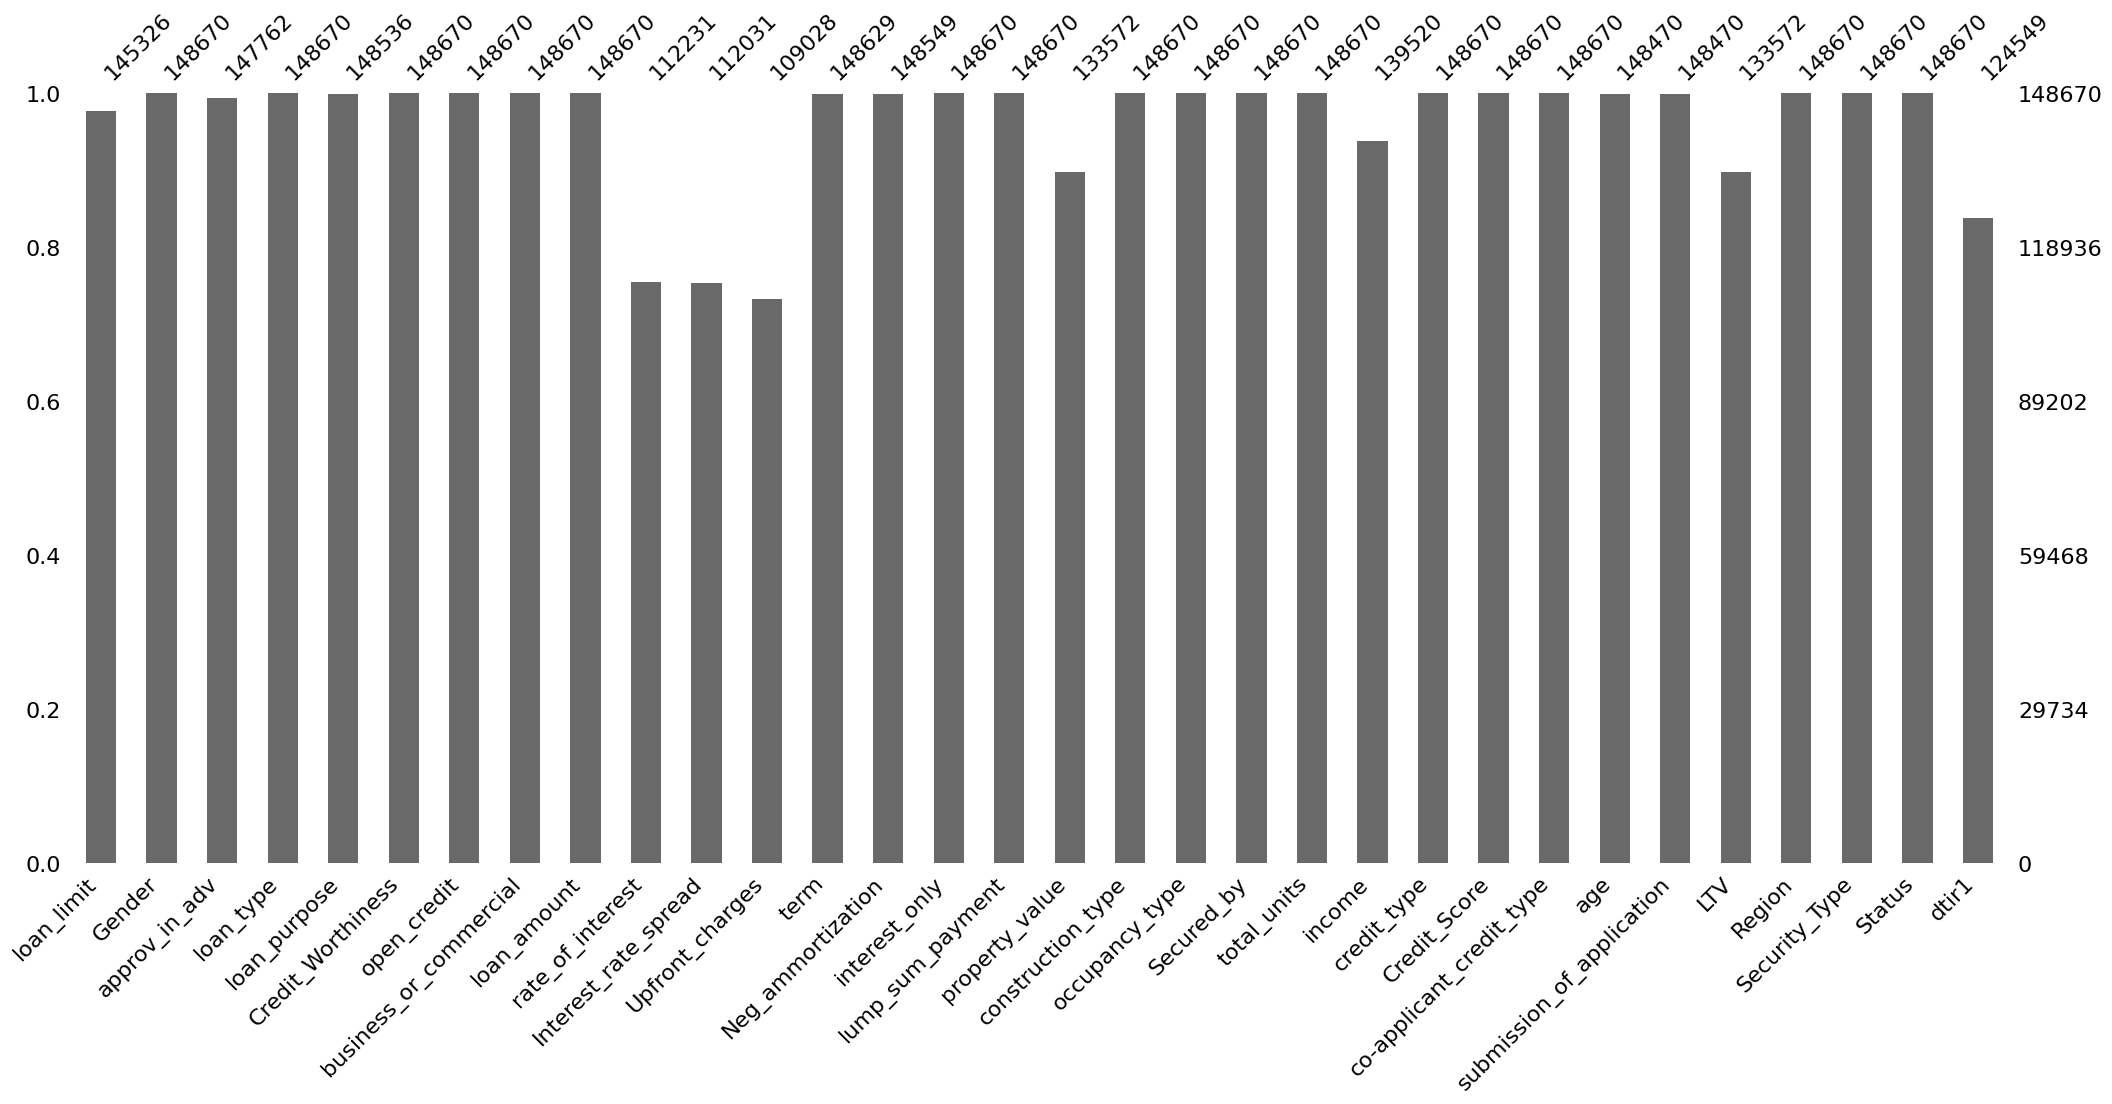

In [13]:
msno.bar(loan_dataframe)

<Axes: >

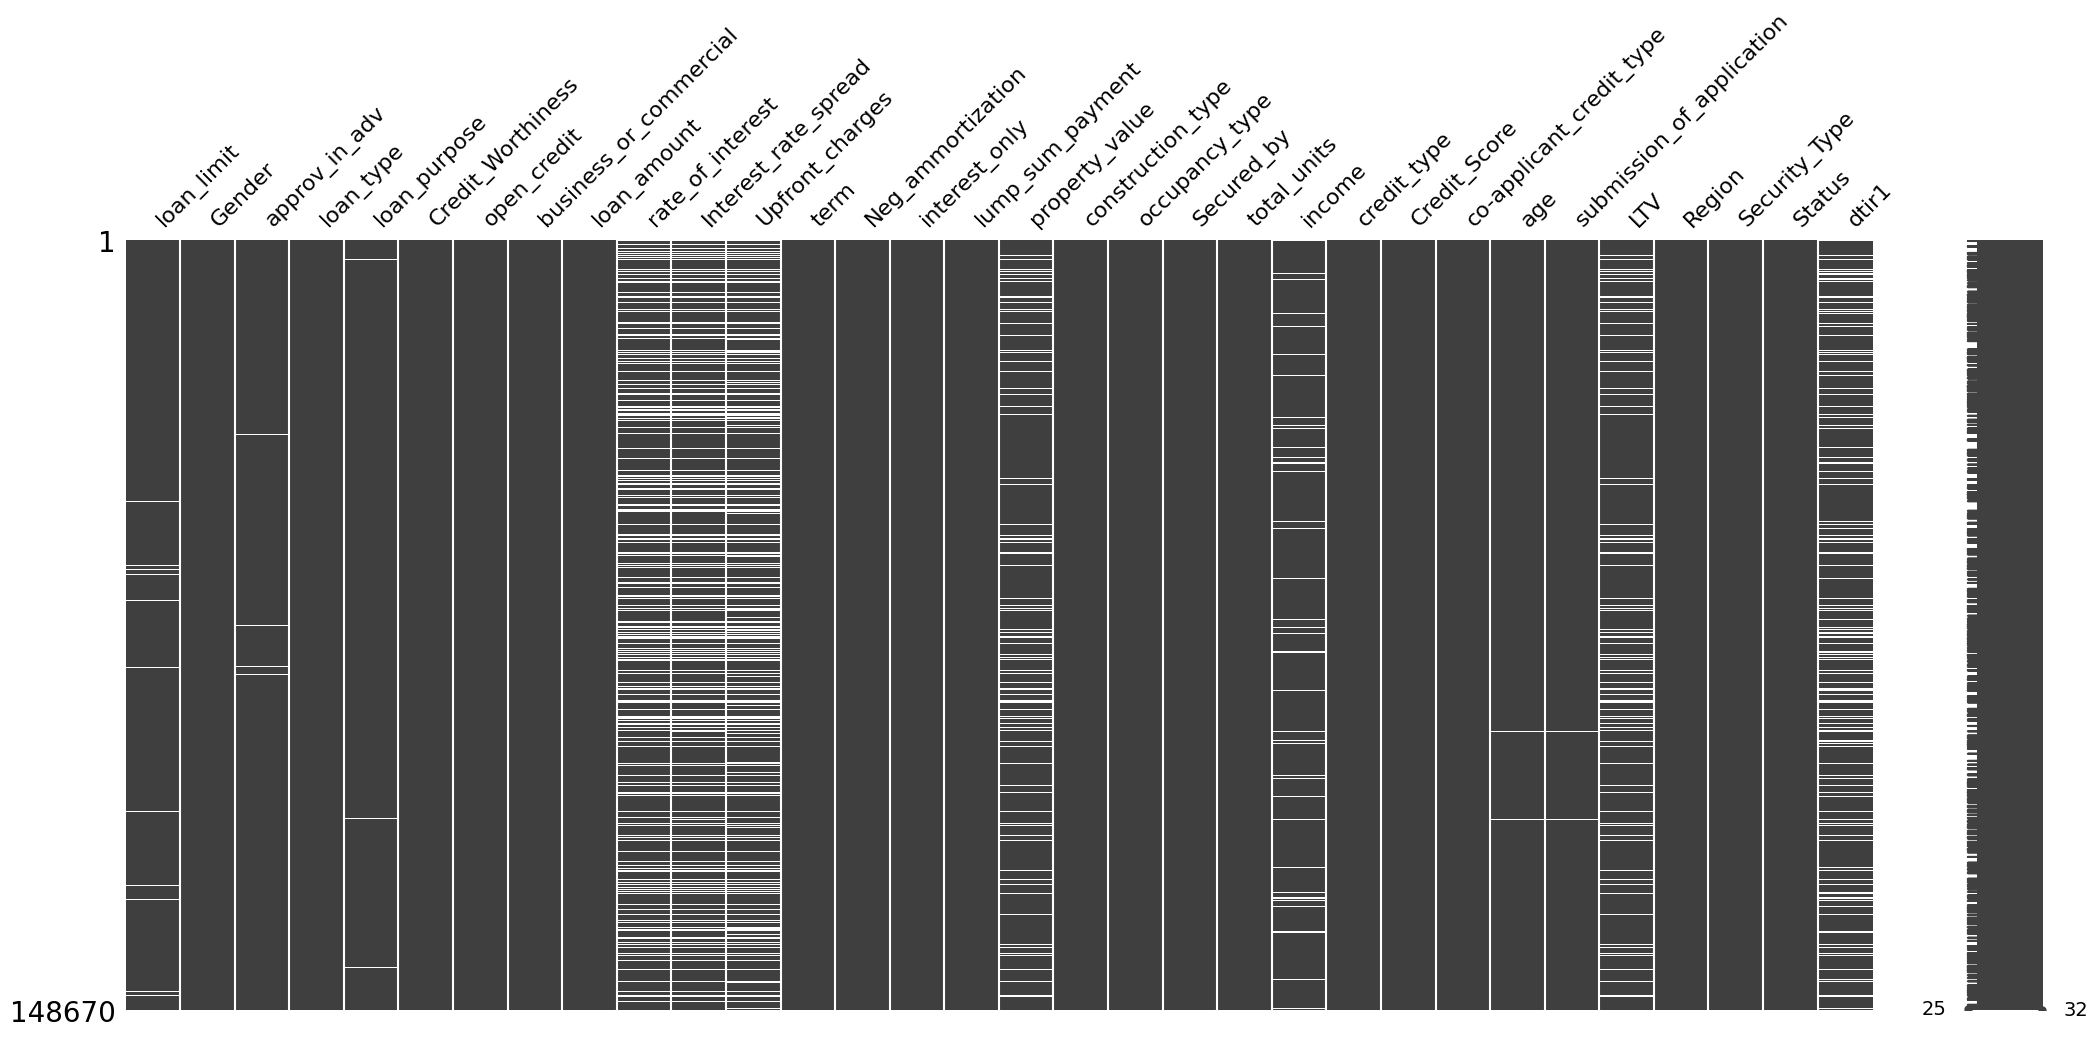

In [14]:
msno.matrix(loan_dataframe)

<Axes: >

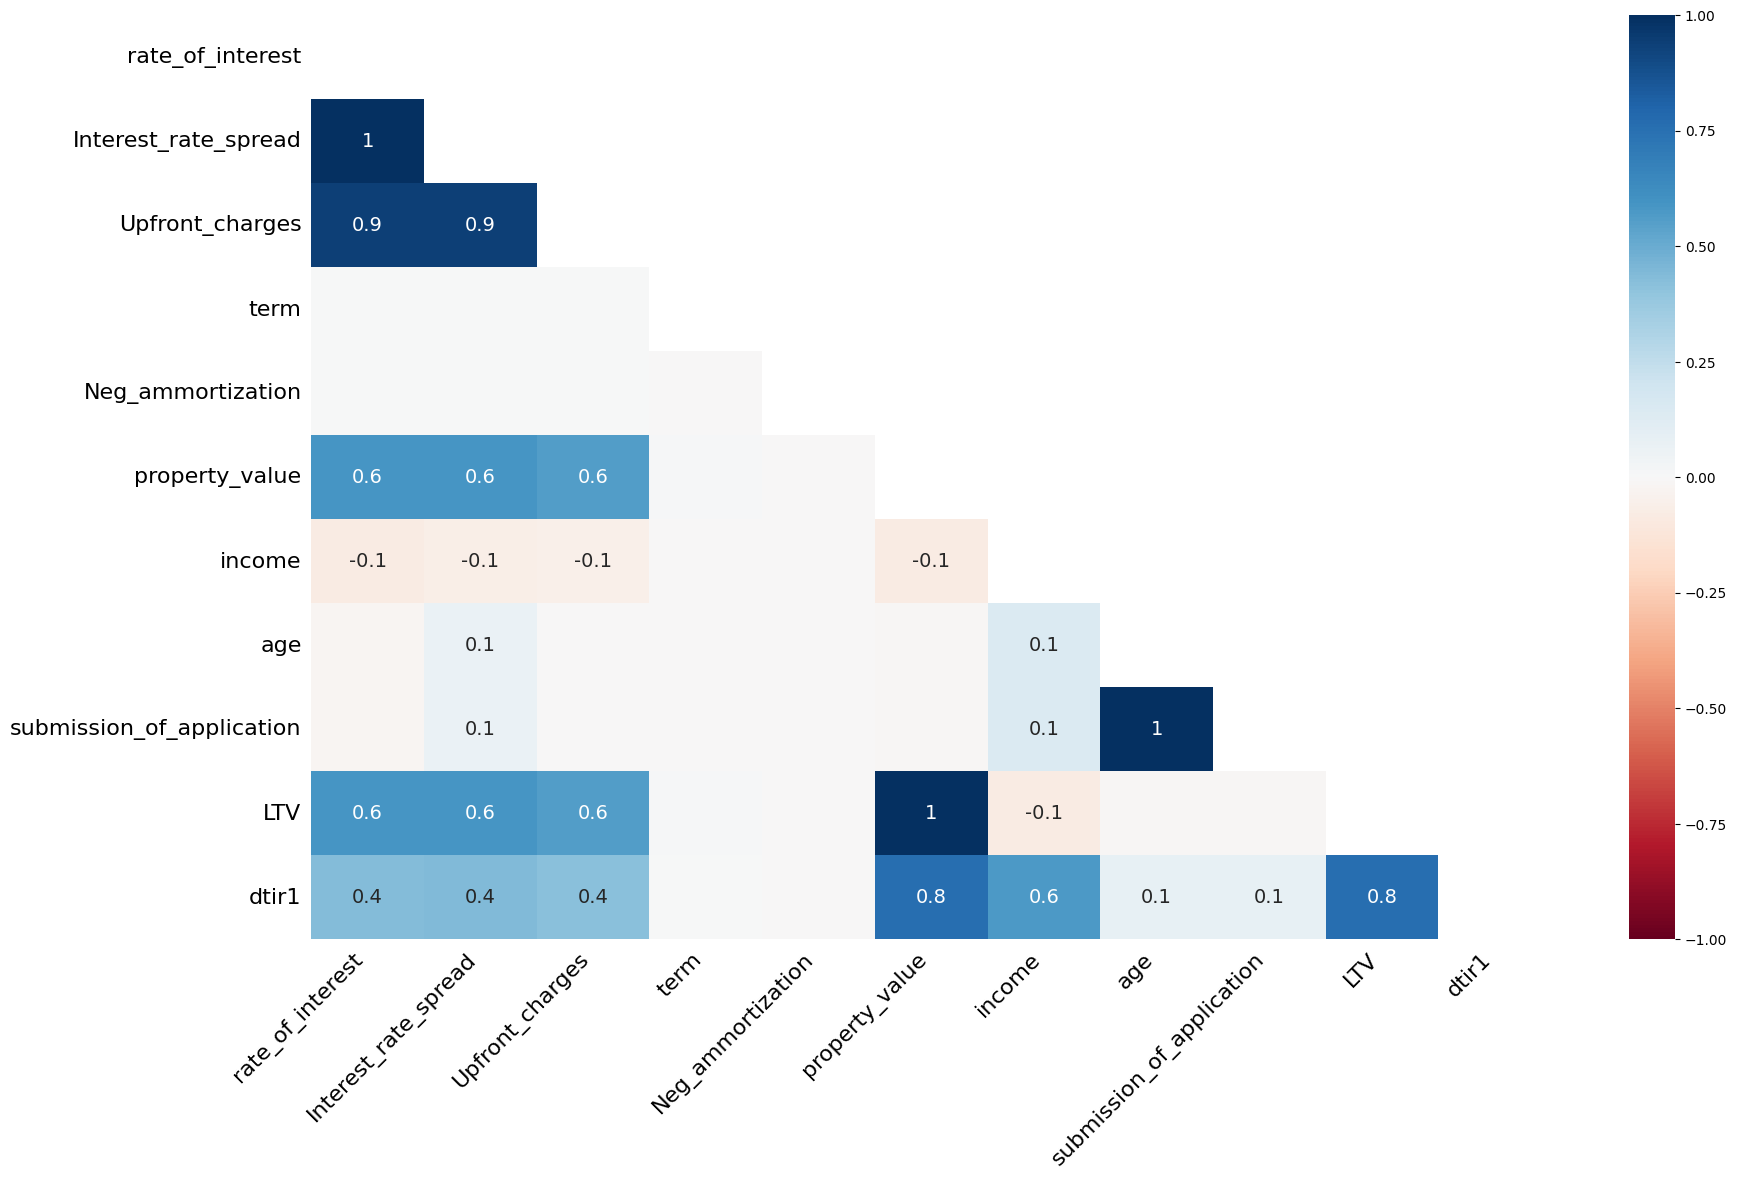

In [15]:
msno.heatmap(loan_dataframe.loc[:, ~loan_dataframe.columns.isin(['loan_limit', 'approv_in_adv', 'loan_purpose'])])

On the missingness of data correlation matrix we can observe some high correlation between certain columns. Based on that we conclude that data are not MCAR (Missing Completly At Random), we assume, that data are MAR (Missing At Random).

The loan_limit, approv_in_adv, submission_of_application, age, loan_purpose, Neg_ammortization, term columns contain small amount of missin data (below 3%) hence rows containing missing data in these columns will be dropped.

In [16]:
loan_df_drop = loan_dataframe.dropna(subset=['loan_limit', 'approv_in_adv', 'submission_of_application', 'age', 'loan_purpose', 'Neg_ammortization', 'term'])
loan_df_drop.shape

(143942, 32)

In [17]:
(148670-143942)/148670

0.03180197753413601

3% of data were dropped 

Number of missing data after deletion:

In [18]:
loan_df_drop.isna().sum()

loan_limit                       0
Gender                           0
approv_in_adv                    0
loan_type                        0
loan_purpose                     0
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             35255
Interest_rate_spread         35255
Upfront_charges              38307
term                             0
Neg_ammortization                0
interest_only                    0
lump_sum_payment                 0
property_value               14597
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        8834
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                              0
submission_of_application        0
LTV                          14597
Region              

In [19]:
missing_cols = loan_df_drop.columns[loan_df_drop.isna().any()].tolist()
missing_cols

['rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'property_value',
 'income',
 'LTV',
 'dtir1']

Other columns contain significant amount of missing data, because of that, rows with missing data can't ber dropped.
Missing data will be imputed using KNN Imputation.

In [20]:
numerical_columns = loan_df_drop.select_dtypes(include=[np.number]).columns.to_list()
categorical_columns = loan_df_drop.select_dtypes(include=['object']).columns.tolist()

In [21]:
numerical_columns

['loan_amount',
 'rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'property_value',
 'total_units',
 'income',
 'Credit_Score',
 'LTV',
 'Status',
 'dtir1']

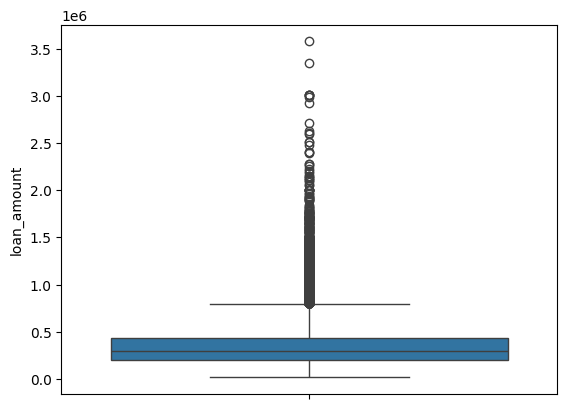

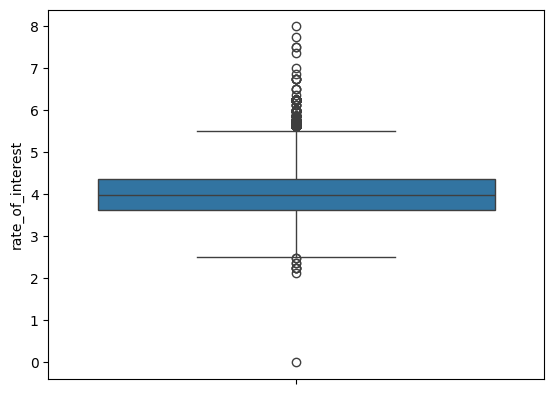

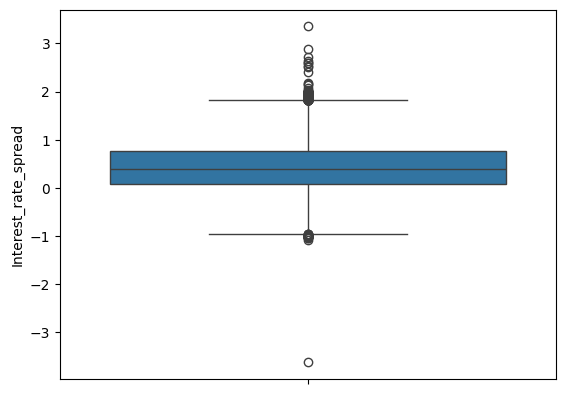

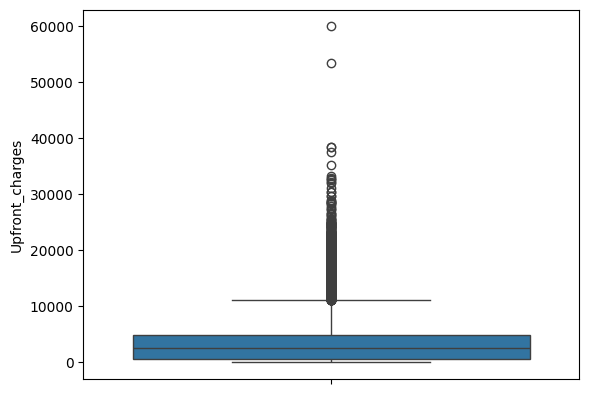

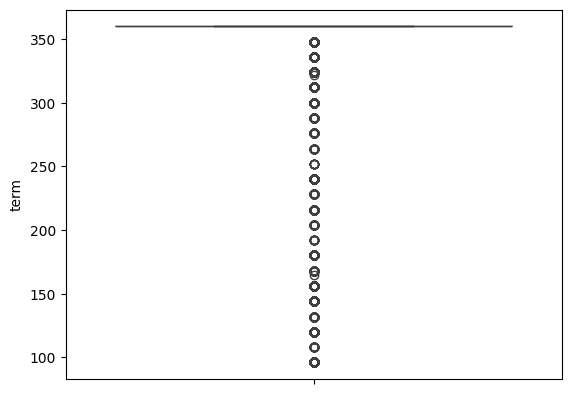

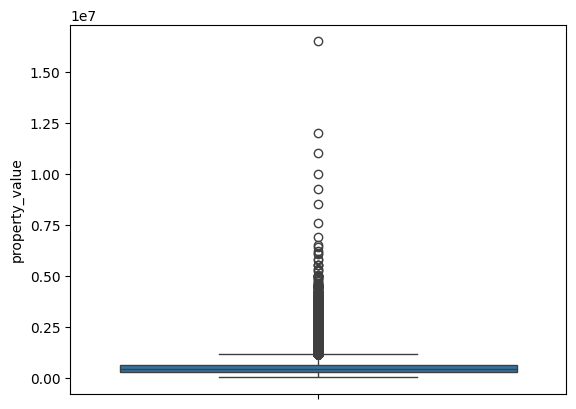

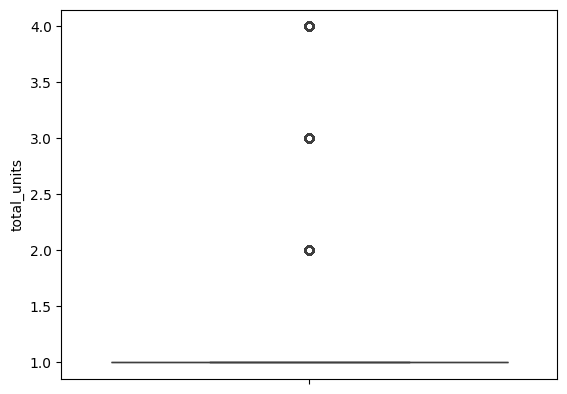

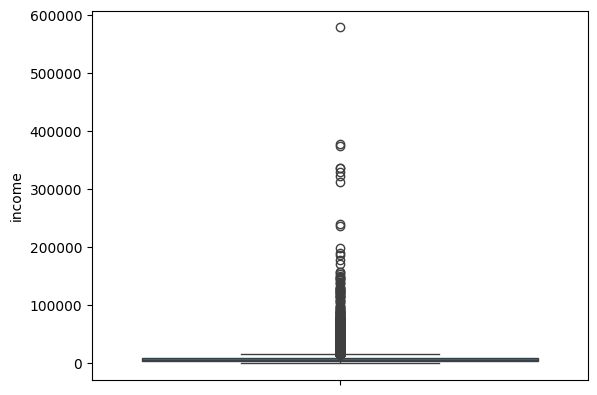

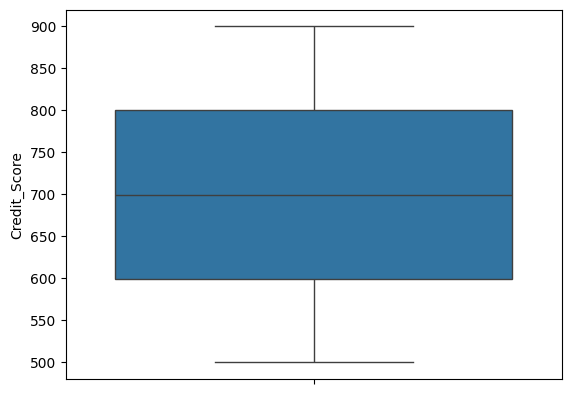

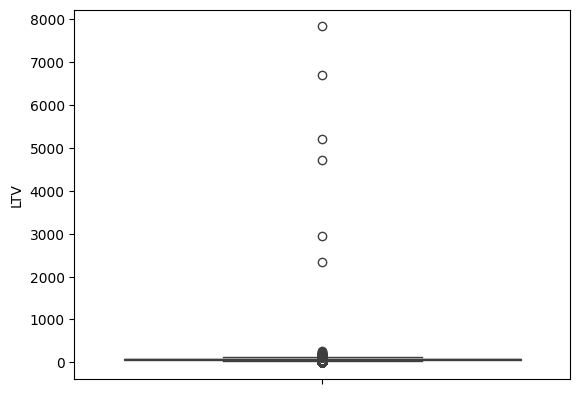

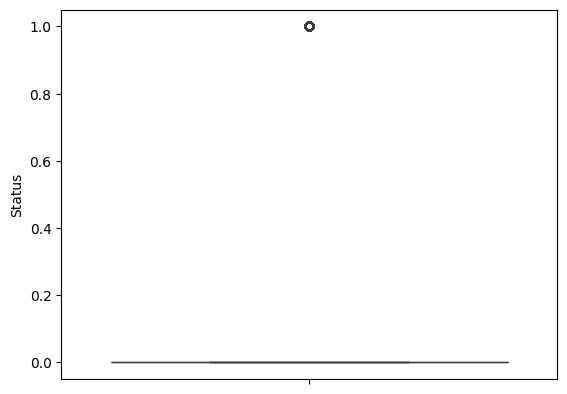

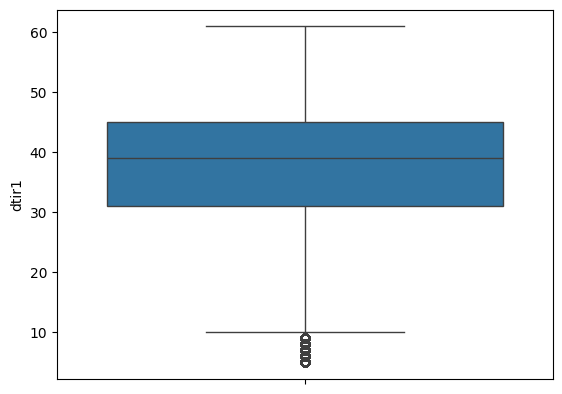

In [31]:
for column in numerical_columns:
        sns.boxplot(data=loan_df_drop[column]) 
        axis.set_title(column)
        plt.show()
      


In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output = False), categorical_columns),
        ('num', RobustScaler(), numerical_columns)
    ],
    remainder='passthrough'
)


In [33]:
transformed_data = preprocessor.fit_transform(loan_df_drop)
columns = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist() + numerical_columns
columns_oh = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist()
df_enc_scal = pd.DataFrame(transformed_data, columns=columns)

def invert_preprocessor(df_imputed):
    inverted_numerical_columns = df_imputed[numerical_columns]
    inverted_categorical_columns = df_imputed[columns_oh]

    # Get RobustScaler from preprocessor
    scaler = preprocessor.named_transformers_['num']

    # Inverse transform the numerical columns
    inverted_numerical_columns = scaler.inverse_transform(inverted_numerical_columns)

    # Get OneHotEncoder from preprocessor
    encoder = preprocessor.named_transformers_['cat']

    # Inverse transform the categorical columns
    inverted_categorical_columns = encoder.inverse_transform(inverted_categorical_columns)

    # Concatenate inverted categorical and numerical columns
    inverted_df = pd.DataFrame(np.concatenate([inverted_categorical_columns, inverted_numerical_columns], axis=1), columns=categorical_columns+numerical_columns)
    return inverted_df


n_neighbors_range = range(2, 13)
inverted_df_list = []

for k in n_neighbors_range:
    # Impute missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=k)
    imputed_data = imputer.fit_transform(df_enc_scal)
    
    # Create DataFrame from imputed data
    imputed_df = pd.DataFrame(imputed_data, columns=df_enc_scal.columns)

    # Store inverted DataFrame
    inverted_df_list.append(invert_preprocessor(imputed_df))

# Plot density comparison for each column and each parameter k
for column in ['dtir1', 'LTV', 'income', 'property_value', 'Upfront_charges', 'Interest_rate_spread', 'rate_of_interest']:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(loan_dataframe[column].dropna(), label='Observed', fill=False)
    for i, k in enumerate(n_neighbors_range):
        sns.kdeplot(inverted_df_list[i][column], label=f'Imputed (k={k})', fill=False)
    plt.title(f'Distribution of {column} - Imputation Comparison')
    plt.legend()
    plt.show()
 
    

In [223]:
df_imputed_inverse = pd.DataFrame(preprocessor.inverse_transform(df_imputed), columns=df_enc_scal.columns)

In [227]:
df_fin = pd.concat([df_imputed_inverse[numerical_columns], loan_dataframe[categorical_columns]], axis=1)
df_fin.shape

(148670, 31)

In [194]:
df_imputed.isna().sum()

loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
rate_of_interest             0
Interest_rate_spread         0
Upfront_charges              0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
property_value               0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
LTV                          0
Region                       0
Security_Type                0
Status                       0
dtir1                        0
dtype: i